## IDs:
ID 1: 204502926 <br>
ID 2: 039065313

## Imports:

In [1]:
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from numpy.linalg import solve

np.random.seed(0)

### Question 1: Data exploration (15 points)

#### Answer:

In [2]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False): 
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=5, bbox={'facecolor':'k', 'pad':5}, color='w')
    ax.set_xlabel(xlab, fontsize=16, labelpad=10)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    plt.xticks(rotation=45)
    plt.hist(dataset[attribute], bins=50, color=bar_color, ec=edge_color, linewidth=2)

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Sparsity: 0.9369533063577546



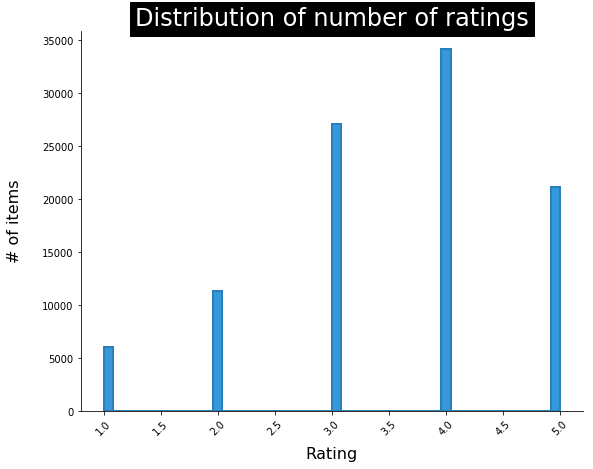

In [3]:
# Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item. 
# Include additional exploration you find relevant to questions 2 and 3.
# Discuss your insights and possible challenges related to the prediction task described in question 2.


# Remember that sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (movies). 
# In other words, dividing the number of ratings present in the matrix by the product of users and movies in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

file_path = 'ml-100k/u.data' # grouplens.org/datasets/movielens/100k

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep='\t', names=names)

print(data.head())

all_users_ids = data.user_id.unique()
all_items_ids = data.item_id.unique()
ratings_count = data.shape[0] # 100,000
users_count = len(all_users_ids)
items_count = len(all_items_ids)
sparsity = 1 - (ratings_count / (users_count * items_count))
print(f'Sparsity: {sparsity}')
print()


make_histogram(data, 'rating', title='Distribution of number of ratings', xlab='Rating', ylab='# of items')

We can see that **'4'** is the dominant rating (34,174 ratings)<br>
The average rating is: $\frac{\sum_{i=1}^n(i * y(i))}{|S|}$, where i is a rating value (1-5), y(i) is the amount of ratings per user/item, and |S| is the size of the dataset (100K).<br>
We can also see that the users are more prone to give a perfect rating ('5') rather than < '3'.

In [4]:
average = sum(data['rating']) / len(data['rating'])
print(f'The average rating is {average}')

The average rating is 3.52986



### Question 2: Matrix factorization model implementation and evaluation (60 points)

#### Answer:

In [5]:
def create_rating_matrix_from_raw_data(df):
    ratings = np.zeros((all_users_ids.shape[0], all_items_ids.shape[0]))

    for row in df.itertuples():
        ratings[row[1]-1][row[2]-1] = row[3]  
        
    return ratings

In [6]:
ratings = create_rating_matrix_from_raw_data(data)
# ratings.shape

In [7]:
def get_5_folds(folds_dir='./ml-100k/'):
    
    
    
    
    
#     change to 5!!!!!!!






    number_of_folds = 2
    header = ['user_id', 'item_id', 'rating', 'timestamp']
    folds = []
    
    for i in range(number_of_folds):     
        print(f'{folds_dir}u{i+1}.base')
        
        df_train = pd.read_csv(f'{folds_dir}u{i+1}.base', sep='\t', names=header)
        df_test = pd.read_csv(f'{folds_dir}u{i+1}.test', sep='\t', names=header)   
        
        rating_train = create_rating_matrix_from_raw_data(df_train)
        rating_test  = create_rating_matrix_from_raw_data(df_test)        
           
        folds.append((rating_train, rating_test))
        
    return folds


folds = get_5_folds()

for fold in folds:
    print(fold[0].shape, fold[1].shape)

./ml-100k/u1.base
./ml-100k/u2.base
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)


In [8]:
from sklearn.metrics import mean_squared_error

def get_rmse(pred, actual):
    # Ignore nonzero terms
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()

    result = np.sqrt(mean_squared_error(pred, actual))
    
    return result


def get_mrr(pred, actual):    
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    matrix = get_relevant_item_matches_matrix_per_user(pred, actual)
    matrix = (np.asarray(r).nonzero()[0] for r in matrix)
    
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in matrix])


def sort_user_ratings(row):
    '''Find the indices of the maximal values in given array'''
    return row.argsort()[-5:][::-1]


def get_relevant_item_matches_matrix_per_user(pred_matrix, actual_matrix):
    '''
    
    Params:
    ======
    RATING_THRESHOLD_VALUE: (int)
            A value between 0-5 (inclusive).
            The minimal value to indicate that both our prediction and the actual rating recommend an item.
            Below that, either the user finds this item relevant and we predicted he wouldn't, or the other way around.
    
    MAX_COLUMNS_CUTOFF: (int)
            A value of 5 or 10 for this exercise.
            The top n items to check for relevancy.
    '''
    RATING_THRESHOLD_VALUE = 3
    MAX_COLUMNS_CUTOFF = 5 # or 10

    top_values_indices = np.apply_along_axis(sort_user_ratings, 1, actual_matrix)
    result = np.zeros_like(top_values_indices)
    rows = len(top_values_indices)
    columns = np.minimum(len(top_values_indices[0]), MAX_COLUMNS_CUTOFF)
    
    for i in range(rows):
        for j in range(columns):
            match = actual_matrix[i][top_values_indices[i][j]] >= RATING_THRESHOLD_VALUE and pred_matrix[i][top_values_indices[i][j]] >= RATING_THRESHOLD_VALUE

            if match:
                result[i][j] = 1
                break

    return result


# actual = np.array([
#     [0, 4, 5, 1, 3, 5], 
#     [0, 5, 4, 1, 4, 4], 
#     [4, 4, 0, 3, 3, 3]])

# pred = np.array([
#     [0, 2, 2, 1, 3, 2], 
#     [0, 3, 5, 1, 5, 5], 
#     [5, 4, 0, 3, 3, 3]])

# print(get_mrr(pred, actual))

In [9]:
MAX_RATING_VALUE = 5
np.random.randint(MAX_RATING_VALUE + 1, size=(2, 4)).astype(float)


array([[4., 5., 0., 3.],
       [3., 3., 1., 3.]])

In [22]:
class ExplicitMFSGD():
    def __init__(self, 
                 ratings,
                 k_factors = 40,
                 item_fact_reg = 0.0, 
                 user_fact_reg = 0.0,
                 item_bias_reg = 0.0,
                 user_bias_reg = 0.0,
                 verbose = False,
                 is_bias_only=False):
        """
        Train a matrix factorization model to predict empty entries in a matrix. 
        The terminology assumes a ratings matrix which is ~ user x item.
        
        (To avoid overfitting we use regularization)

        Params
        ======
        ratings: (ndarray)
            User x Item matrix with corresponding ratings
        
        k_factors: (int)
            Number of latent factors to use in matrix factorization model
        
        item_fact_reg: (float)
            Regularization term for item latent factors
            
        user_fact_reg: (float)
            Regularization term for user latent factors
            
        item_bias_reg: (float)
            Regularization term for item biases
        
        user_bias_reg: (float)
            Regularization term for user biases
        
        verbose: (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count
        self.k_factors = k_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        self._v = verbose
        self.is_bias_only = is_bias_only
        self.curr_iter = 1
        self.user_vecs, self.item_vecs = None, None
        self.debug_counter = 0

    def calculate_learning_curve(self, iter_array, test, learning_rate):
        iter_array.sort()
        self.init_for_train(learning_rate)
        training_rmse, test_rmse, training_mrr, test_mrr = [], [], [], []
        
        for n_iter in iter_array:
            if self.is_bias_only:
                self.print_verbose(f'Bias-only model')
            
            self.print_verbose(f'k={self.k_factors}, alpha={learning_rate}, '\
                              f'iterations={n_iter}, item_fact_reg={self.item_fact_reg}, '\
                              f'user_fact_reg={self.user_fact_reg}, item_bias_reg={self.item_bias_reg}, '\
                              f'user_bias_reg={self.user_bias_reg}')
            self.train(n_iter)
            predictions = self.get_prediction_matrix()
#             try:
            self.evaluate(predictions, test, training_rmse, test_rmse, training_mrr, test_mrr)
#             except:
#                 print(f'self.global_bias: {self.global_bias}')
#                 print(f'self.user_bias[user]: {self.user_bias}')
#                 print(f'self.item_bias[item]: {self.item_bias}')
#                 print(f'self.debug_counter: {self.debug_counter}')
#                 print('----')
                
        print('============================================')
        
        return training_rmse, test_rmse, training_mrr, test_mrr
    
    
    def init_for_train(self, learning_rate=0.1):        
        # initialize latent vectors
        # Approximate rating matrix by product of lower rank matrix
        self.user_vecs = np.random.randint(MAX_RATING_VALUE + 1, size=(self.users_count, self.k_factors)).astype(float)
        self.item_vecs = np.random.randint(MAX_RATING_VALUE + 1, size=(self.items_count, self.k_factors)).astype(float)
#         self.item_vecs = np.random.random((self.items_count, self.k_factors))
        
        self.learning_rate = learning_rate
        self.user_bias = np.zeros(self.users_count)
        self.item_bias = np.zeros(self.items_count)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])

    def train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        while self.curr_iter <= n_iter:
            if self.curr_iter % 10 == 0 and n_iter > 10 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {self.curr_iter}')
                
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            self.perform_sgd()
            self.curr_iter += 1
            
    def predict(self, user, item):
        """
        Single user and item prediction
        """
        try:
            self.debug_counter += 1
            biases = self.global_bias + self.user_bias[user] + self.item_bias[item]
            prediction_value = biases

            if not self.is_bias_only: # bias-only model
                prediction_value += self.user_vecs[user, :].dot(self.item_vecs[item, :].T)
        except:
            print(f'self.global_bias: {self.global_bias}')
            print(f'self.user_bias[user]: {self.user_bias[user]}')
            print(f'self.item_bias[item]: {self.item_bias[item]}')
            print(f'prediction_value: {prediction_value}')
            print(f'self.debug_counter: {self.debug_counter}')
            print('----')
        
        return prediction_value
    
    def perform_sgd(self):
        for idx in self.training_indices:
            user = self.sample_row[idx]
            item = self.sample_col[idx]
            prediction = self.predict(user, item)
            actual_rating = self.ratings[user, item] # get actual rating from the dataset's ratings array 
            error = actual_rating - prediction
            
            # Update biases
            self.user_bias[user] += (self.learning_rate * (error - self.user_bias_reg * self.user_bias[user]))
            self.item_bias[item] += (self.learning_rate * (error - self.item_bias_reg * self.item_bias[item]))
            
            # Update latent factors
            self.user_vecs[user, :] += self.learning_rate * (error * self.item_vecs[item, :] - self.user_fact_reg * self.user_vecs[user,:])
            self.item_vecs[item, :] += self.learning_rate * (error * self.user_vecs[user, :] - self.item_fact_reg * self.item_vecs[item,:])
    
    def get_prediction_matrix(self):
        """
        Predict ratings for every user and item
        """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        
        for user in range(self.user_vecs.shape[0]):
            for item in range(self.item_vecs.shape[0]):
                predictions[user, item] = self.predict(user, item)
                
        return predictions
    
    def evaluate(self, predictions, test, training_rmse, test_rmse, training_mrr, test_mrr):
        original = copy.deepcopy(predictions)
        training_rmse.append(get_rmse(predictions, self.ratings))
        test_rmse.append(get_rmse(predictions, test))

        training_mrr.append(get_mrr(predictions, self.ratings))
        test_mrr.append(get_mrr(predictions, test))
        
        self.print_verbose(f'Training RMSE = {training_rmse[-1]}')
        self.print_verbose(f'Test RMSE = {test_rmse[-1]}')
        
        self.print_verbose(f'Training MRR = {training_mrr[-1]}')
        self.print_verbose(f'Test MRR = {test_mrr[-1]}')

    def print_verbose(self, msg):
        if self._v:
            print(msg)

In [11]:
class ExplicitMFALS:
    def __init__(self,
                 ratings,
                 k_factors=40,
                 item_reg=0.0,
                 user_reg=0.0,
                 verbose=False):
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count        
        self.k_factors = k_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose
        self.curr_iter = 1

    def calculate_learning_curve(self, iter_array, test):
        iter_array.sort()
        self.init_for_train()
        training_rmse, test_rmse, training_mrr, test_mrr = [], [], [], []
        
        for n_iter in iter_array:            
            self.print_verbose(f'k={self.k_factors}, '\
                               f'iterations={n_iter}, '\
                               f'item_reg={self.item_reg}, '\
                               f'user_reg={self.user_reg}')
            self.train(n_iter)
            predictions = self.predict_all()
            self.evaluate(predictions, test, training_rmse, test_rmse, training_mrr, test_mrr)  
        
        print('============================================')
        
        return training_rmse, test_rmse, training_mrr, test_mrr
    
    def als_step_user(self):
        YTY = self.item_vecs.T.dot(self.item_vecs)
        lambdaI = np.eye(YTY.shape[0]) * self.user_reg

        for u in range(self.user_vecs.shape[0]):
            self.user_vecs[u, :] = solve((YTY + lambdaI), self.ratings[u, :].dot(self.item_vecs))

    def als_step_item(self):
        XTX = self.user_vecs.T.dot(self.user_vecs)
        lambdaI = np.eye(XTX.shape[0]) * self.item_reg

        for i in range(self.item_vecs.shape[0]):
            self.item_vecs[i, :] = solve((XTX + lambdaI), self.ratings[:, i].T.dot(self.user_vecs))

    def init_for_train(self):
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1. / self.k_factors,
                                          size=(self.users_count, self.k_factors))
        self.item_vecs = np.random.normal(scale=1. / self.k_factors,
                                          size=(self.items_count, self.k_factors))
        print(f'user_vecs: {self.user_vecs.shape}, item_vecs: {self.item_vecs.shape}')

    def train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        while self.curr_iter <= n_iter:
            if self.curr_iter % 10 == 0 and n_iter > 10 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {self.curr_iter}')
                
            self.als_step_user()
            self.als_step_item()
            self.curr_iter += 1
            
    def predict(self, u, i):
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)

    def predict_all(self):
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
        return predictions
                       
    def evaluate(self, predictions, test, training_rmse, test_rmse, training_mrr, test_mrr):
        training_rmse.append(get_rmse(predictions, self.ratings))
        test_rmse.append(get_rmse(predictions, test))

        training_mrr.append(get_mrr(predictions, self.ratings))
        test_mrr.append(get_mrr(predictions, test))
        
        self.print_verbose(f'Training RMSE = {training_rmse[-1]}')
        self.print_verbose(f'Test RMSE = {test_rmse[-1]}')
        
        self.print_verbose(f'Training MRR = {training_mrr[-1]}')
        self.print_verbose(f'Test MRR = {test_mrr[-1]}')
        
    def print_verbose(self, msg):
        if self._v:
            print(msg)        

In [12]:
import copy
from itertools import combinations, combinations_with_replacement, permutations

def permutation_regularization_generator(base_dict):
#     regularization_parameters_values = [0.01, 0.1, 1.0]
    regularization_parameters_values = [0.01]
    regularization_permutations = set()
    number_of_regularization_params = len(base_dict)
    
    for seq in list(combinations_with_replacement(regularization_parameters_values, number_of_regularization_params)):
        for perm_seq in permutations(seq, number_of_regularization_params):
            regularization_permutations.add(perm_seq)

    regularization_parameters_dict_list = []      
    keys = base_dict.keys()
    
    for perm in regularization_permutations:
        curr_values_dict = copy.deepcopy(base_dict)
        
        for idx, key in enumerate(keys):
            curr_values_dict[key] = perm[idx]
        
        regularization_parameters_dict_list.append(curr_values_dict)
        
    return regularization_parameters_dict_list

In [13]:
def generate_list_of_regularization_parameters_values(model_type):
    if model_type.lower() == "als":
        base_dict = {'item_reg': 0.0, 'user_reg':0.0}
    else: # model type == "sgd"
        base_dict = {'item_fact_reg': 0.0, 'user_fact_reg': 0.0, 'item_bias_reg': 0.0, 'user_bias_reg':0.0}
        
    return permutation_regularization_generator(base_dict)        

    
def als_model_provider(**params):
    return ExplicitMFALS(**params)


def sgd_model_provider(**params):
    return ExplicitMFSGD(**params)

In [14]:
# CODE EXAMPLE ON HOW I PASSED PARAMS:

def y(a=0, b=1, c=2, d=3):
    print(f'a:{a}, b:{b}, c:{c}, d:{d}')
    
def x(**params):
    y(**params)
    
last_params = {'c': 35, 'd': 45}
x(a=10,b=20,**last_params)   

a:10, b:20, c:35, d:45


In [15]:
def calculate_learning_curve(training_data, test_data, model_provider, model_type="sgd"):
    regularization_parameters_values = generate_list_of_regularization_parameters_values(model_type)    
    perm_count = 1
    params_and_results = []
    
    if model_type.lower() == "als":
        hyper_param_learning_iter_num = len(k_options)*len(regularization_parameters_values)
    else: # sgd
        hyper_param_learning_iter_num = len(k_options)*len(learning_rate_options)*len(regularization_parameters_values)
        
    for k in k_options:
        if model_type.lower() == "als":
            for regularization_parameters_value in regularization_parameters_values:    
                print(f'iteration {perm_count}/{hyper_param_learning_iter_num}')
                model = model_provider(ratings=training_data, k_factors=k, verbose=True, **regularization_parameters_value)
                training_rmse, test_rmse, training_mrr, test_mrr = model.calculate_learning_curve(iter_array, test_data)
                curr_run_params_and_results = {"k": k, "training_rmse": training_rmse, "test_rmse": test_rmse, "training_mrr": training_mrr, "test_mrr": test_mrr}
                params_and_results.append({**curr_run_params_and_results, **regularization_parameters_value})    
                perm_count += 1
        else: # sgd
            for learning_rate in learning_rate_options:
                for regularization_parameters_value in regularization_parameters_values:    
                    print(f'iteration {perm_count}/{hyper_param_learning_iter_num} ')
                    model = model_provider(ratings=training_data, k_factors=k, verbose=True, is_bias_only=False, **regularization_parameters_value)
                    training_rmse, test_rmse, training_mrr, test_mrrיא = model.calculate_learning_curve(iter_array, test_data, learning_rate)
                    curr_run_params_and_results = {"k": k, "learning_rate": learning_rate, "training_rmse": training_rmse, "test_rmse": test_rmse, "training_mrr": training_mrr, "test_mrr": test_mrr}
                    params_and_results.append({**curr_run_params_and_results, **regularization_parameters_value})    
                    perm_count += 1
                    
    return params_and_results

In [16]:
# OFFICIAL AND FINAL PARAMETERS FOR SUBMISSION
k_options = [5, 10, 20]
learning_rate_options = [0.001, 0.01, 0.1]
iter_array = [1, 5, 10, 25, 50, 100, 200]

# DEMO AND SMALLER PARAMETERS - NOT FOR SUBMISSION
k_options = [5, 10]
learning_rate_options = [0.1]
iter_array = [1, 10, 25]

In [18]:
def get_number_of_permutations_string(model_type="sgd"):
    regularization_parameters_values = generate_list_of_regularization_parameters_values(model_type)
    print(f'Total of {len(regularization_parameters_values)} regularization parameters permutations')

    if model_type.lower() == "als":
        permutations_string = "(|k's| * |reg's|^2)"
        hyper_param_learning_iter_num = len(k_options)*len(regularization_parameters_values)
    else: # sgd
        permutations_string = "(|k's| * |alphas| * |reg's|^4)"
        hyper_param_learning_iter_num = len(k_options)*len(learning_rate_options)*len(regularization_parameters_values)

    print(f'For each fold - {hyper_param_learning_iter_num} permutations (runs) on the model parameters {permutations_string}')

## Train/Test/Collect ALS 5-folds

In [ ]:
als_folds_results = []

get_number_of_permutations_string(model_type="als")
    
for idx, fold in enumerate(folds, start = 0):
    print('============================================')
    print(f'Running on fold {idx}/{len(folds) - 1}')
    training_data, test_data = fold
    params_and_results = calculate_learning_curve(training_data, test_data, model_provider=als_model_provider, model_type="als")
    als_folds_results.append(params_and_results)

## Train/Test/Collect SGD 5-folds

In [23]:
sgd_folds_results = []

get_number_of_permutations_string(model_type="sgd")

for idx, fold in enumerate(folds, start = 0):
    print('============================================')
    print(f'Running on fold {idx}/{len(folds) - 1}')
    training_data, test_data = fold
    params_and_results = calculate_learning_curve(training_data, test_data, model_provider=sgd_model_provider, model_type="sgd")
    sgd_folds_results.append(params_and_results)

Total of 1 regularization parameters permutations
For each fold - 2 permutations (runs) on the model parameters (|k's| * |alphas| * |reg's|^4)
Running on fold 0/1
iteration 1/2 
k=5, alpha=0.1, iterations=1, item_fact_reg=0.01, user_fact_reg=0.01, item_bias_reg=0.01, user_bias_reg=0.01


c:\users\on737092\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: overflow encountered in multiply
c:\users\on737092\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: overflow encountered in multiply
c:\users\on737092\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in subtract
c:\users\on737092\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in add


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from collections import defaultdict

def generate_key(dict_item, model_type="sgd"):
    if model_type.lower() == "als":
        key = f"k_{dict_item['k']}_ir_{dict_item['item_reg']}_ur_{dict_item['user_reg']}"
    else:
        key = f"k_{dict_item['k']}_lr_{dict_item['learning_rate']}_if_{dict_item['item_fact_reg']}_uf_{dict_item['user_fact_reg']}_ib_{dict_item['item_bias_reg']}_ub_{dict_item['user_bias_reg']}"
    
    return key


def calculate_average(matrix):
    '''
    Take the mean of each column from a given matrix
    '''
    return np.mean(matrix, axis=0)


def get_average_map(given_map):
    for key, value in given_map.items():
        matrix = np.array(value)
        new_value = calculate_average(matrix)
        given_map[key] = new_value
        
    return given_map


def create_error_map(folds_results_list, key_name, model_type="sgd"):
    results_map = defaultdict(list)

    for fold_result in folds_results_list:
        for dict_item in fold_result:
            generated_key = generate_key(dict_item, model_type)
            current_error_list = dict_item[key_name]
            results_map[generated_key].append(current_error_list)
            
    results_map = get_average_map(results_map)
    
    return results_map


def combine_training_and_test_averages_per_model(folds_results_list, averages_training_map, averages_test_map, key_names, model_type="sgd"):
    averaged_folds_results = []
    
    for fold_result in folds_results_list[0]:
        dict_copy = fold_result.copy()
        
        dict_copy[key_names[0]] = averages_training_map[generate_key(fold_result, model_type)]
        dict_copy[key_names[1]] = averages_test_map[generate_key(fold_result, model_type)]
        
        averaged_folds_results.append(dict_copy)
            
    return averaged_folds_results

In [ ]:
# demo = [
#     [
#     {'k': 10,
#    'learning_rate': 0.001,
#    'training_rmse': [0,0,0],
#    'test_rmse': [1,1,1],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0},
#        {'k': 20,
#    'learning_rate': 0.001,
#    'training_rmse': [1,2,3],
#    'test_rmse': [0,0,0],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0}
#        ],
#     [
#     {'k': 10,
#    'learning_rate': 0.001,
#    'training_rmse': [1,1,1],
#    'test_rmse': [2,2,2],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0},
#        {'k': 20,
#    'learning_rate': 0.001,
#    'training_rmse': [5,5,5],
#    'test_rmse': [5,5,5],
#    'item_fact_reg': 100.0,
#    'user_fact_reg': 100.0,
#    'item_bias_reg': 100.0,
#    'user_bias_reg': 100.0}
#        ],
# ]

# demo

In [ ]:

# ============= RMSE
training_sgd_averages_map_rmse = create_error_map(sgd_folds_results, 'training_rmse', model_type="sgd")
test_sgd_averages_map_rmse = create_error_map(sgd_folds_results, 'test_rmse', model_type="sgd")

training_als_averages_map_rmse = create_error_map(als_folds_results, 'training_rmse', model_type="als")
test_als_averages_map_rmse = create_error_map(als_folds_results, 'test_rmse', model_type="als")


# ============= MRR

# training_sgd_mrr
# test_sgd_mrr
training_als_averages_map_mrr = create_error_map(als_folds_results, 'training_mrr', model_type="als")
test_als_averages_map_mrr = create_error_map(als_folds_results, 'test_mrr', model_type="als")

# ============= nDCG


print(training_sgd_averages_map_rmse)
print(test_sgd_averages_map_rmse)
print()
print(training_als_averages_map_rmse)
print(test_als_averages_map_rmse)
print()
print(training_als_averages_map_mrr)
print(test_als_averages_map_mrr)

In [ ]:
key_names_array=['training_rmse', 'test_rmse', 'training_mrr', 'test_mrr']
sgd_averages_result_rmse = combine_training_and_test_averages_per_model(sgd_folds_results, training_sgd_averages_map_rmse, test_sgd_averages_map_rmse, key_names=['training_rmse', 'test_rmse'], model_type="sgd")
print(sgd_averages_result_rmse)
print()

als_averages_result = combine_training_and_test_averages_per_model(als_folds_results, training_als_averages_map_rmse, test_als_averages_map_rmse, key_names=key_names_array, model_type="als")
print(als_averages_result)

In [ ]:
sns.set()

def plot_learning_curve_list(iter_array, predictions, title, error_method, mse_extractor, model_type="als"):
    plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

    for prediction in predictions:
        k = prediction["k"]
        
        if model_type.lower() == "als":
            ir, ur = prediction['item_reg'], prediction['user_reg']
            plt.plot(iter_array, mse_extractor(prediction), label=f"{title} k={k}, item_reg={ir}, user_reg={ur}", linewidth=5)
        else:
            learning_rate = prediction["learning_rate"]
            if_reg, uf_reg, ib, ub = prediction['item_fact_reg'], prediction['user_fact_reg'], prediction['item_bias_reg'], prediction['user_bias_reg']
            plt.plot(iter_array, mse_extractor(prediction), label=f"{title} k={k}, α={learning_rate}, if={if_reg}, uf={uf_reg}, if={if_reg}, uf={uf_reg}, ib={ib}, ub={ub}", linewidth=5)
    
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=20);
    plt.ylabel(f'{error_method} (averaged)', fontsize=20);
    plt.title(f'{title} - {model_type.upper()} - ({error_method})', fontsize=30, bbox={'facecolor':'k', 'pad':5}, color='w')
    plt.legend(loc='best', fontsize=12)

In [ ]:
TITLE_TRAINING = 'TRAINING'
TITLE_TEST = 'TEST'
ERROR_METHOD_RMSE = 'RMSE'
ERROR_METHOD_MRR = 'MRR'
ERROR_METHOD_NDCG = 'NDCG'

In [ ]:
plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method = ERROR_METHOD_RMSE, mse_extractor=lambda model: model["training_rmse"], model_type="sgd", predictions=sgd_averages_result_rmse)
plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method = ERROR_METHOD_RMSE, mse_extractor=lambda model: model["test_rmse"], model_type="sgd", predictions=sgd_averages_result_rmse)

In [ ]:
plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method=ERROR_METHOD_RMSE, mse_extractor=lambda model: model["training_rmse"], model_type="als", predictions=als_averages_result)
plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method=ERROR_METHOD_RMSE, mse_extractor=lambda model: model["test_rmse"], model_type="als", predictions=als_averages_result)

In [ ]:
plot_learning_curve_list(iter_array, title=TITLE_TRAINING, error_method=ERROR_METHOD_MRR, mse_extractor=lambda model: model["training_mrr"], model_type="als", predictions=als_averages_result)
plot_learning_curve_list(iter_array, title=TITLE_TEST, error_method=ERROR_METHOD_MRR, mse_extractor=lambda model: model["test_mrr"], model_type="als", predictions=als_averages_result)

### Question 3: Matrix factorization – item similarity and model explainability (25 points)

#### Answer: